# 1 Preparation
### 1.1 Setup notebook

In [12]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import KMeans 
from mpl_toolkits import mplot3d
import ipywidgets as widgets
from ipywidgets import interact, interactive
from bqplot import pyplot as blot
from bqplot import marks as marks
import datetime as datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import fbprophet

#set graphical parameters
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["figure.figsize"] = 15, 7.5

### 1.2 Import and pre-process data:

In [16]:
#import data
raw = pd.read_csv("/Users/nicolausholzach/Desktop/Dateien/Ubiqum/Projects/Project 3/P3_Task 1/household_power_consumption.txt", \
                  sep = ";", parse_dates = [["Date", "Time"]], infer_datetime_format = True, index_col = "Date_Time")

#clean data
df = raw.replace("?", np.nan).copy() #replace ? with NaN
df = df.fillna(method="ffill") #replace NaN with last known instance in past
df = df.apply(pd.to_numeric) #convert all values to floats

#create df for full years only
full_year = df.loc["2007":"2009"].copy() #only includes year with data for each day

#convert submetering from watt-hour to kilowatt-hour
full_year["Sub_metering_1"] = full_year["Sub_metering_1"] / 1000
full_year["Sub_metering_2"] = full_year["Sub_metering_2"] / 1000
full_year["Sub_metering_3"] = full_year["Sub_metering_3"] / 1000

#add global_energy column
full_year["global_energy"] = full_year["Global_active_power"] / 60 #global energy in kWh
full_year["remaining_energy"] = full_year["global_energy"] - full_year["Sub_metering_1"] - \
                                full_year["Sub_metering_2"] - full_year["Sub_metering_3"]
#create submeter dataframes and convert to kWh
kitchen = full_year["Sub_metering_1"] 
laundry = full_year["Sub_metering_2"]
heating = full_year["Sub_metering_3"]

submeter = pd.concat([full_year["remaining_energy"], kitchen, laundry, heating], axis=1)
submeter.columns = ["remaining energy", "kitchen", "laundry", "heating"]

#grouping data
monthly_data = full_year.groupby(pd.Grouper(freq="M")).sum() #monthly
monthly_submeter = submeter.groupby(pd.Grouper(freq="M")).sum() #monthly
hourly_data = full_year.groupby(pd.Grouper(freq="H")).sum() #hourly
hourly_submeter = submeter.groupby(pd.Grouper(freq="H")).sum() #hourly

##### Add seasonal information to dataframe: 
(Note that this omits the official starting date of each season)

In [20]:
#create dictionary for seasons
seasons = {1:"Winter", 2:"Winter", 3:"Spring", 4:"Spring", 5:"Spring", 6:"Summer", \
          7:"Summer", 8:"Summer", 9:"Fall", 10:"Fall", 11:"Fall", 12:"Winter"}

#define function to add season column
def add_season(data_list):
    for i in data_list:
        i["season"] = i.index.month.map(seasons)

#add season column to full_year, monthly, and hourly data
season_data_list = [full_year, monthly_data, monthly_submeter, hourly_data, hourly_submeter] #list of all df's to be edited
add_season(season_data_list) #edit df's from list

# 2 High-level Exploratory Analysis
### 2.1 Monthly energy consumption

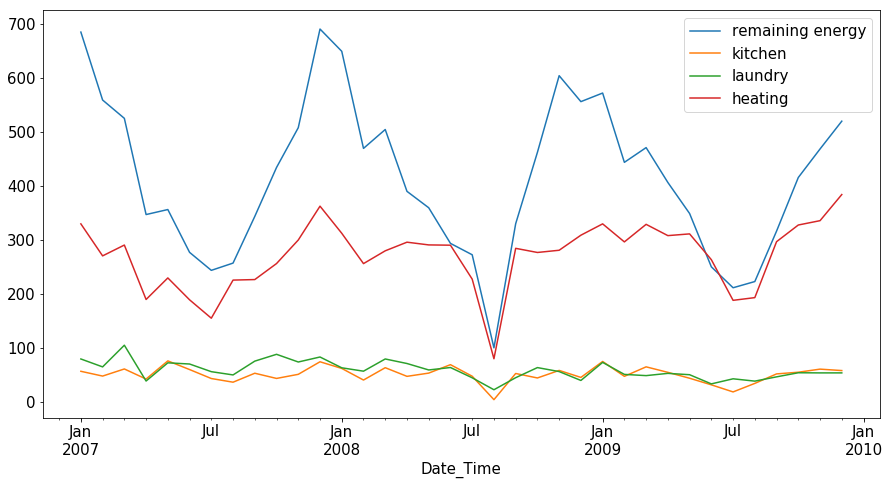

In [23]:
#define function to export graph
def export_graph(data, kind, figsize, filepath):
    ax = data.plot(kind=kind, figsize=figsize)
    fig = ax.get_figure()
    fig.savefig(filepath)
    
#export monthly energy data    
export_graph(monthly_submeter, kind = "line", figsize = (15, 7.5), \
             filepath = "/Users/nicolausholzach/Desktop/Dateien/Ubiqum/Projects/Project 3/P3_Task 1/Monthly Energy.png")

### 2.2 Daily energy consumption


In [4]:
#define function to calculate average hourly consumption and
def hourly_averages(data):
    seasonal = data.copy()
    seasonal["hour"] = seasonal.index.hour
    seasonal = seasonal.groupby(["season", "hour"]).mean()
    seasonal = seasonal.reset_index()
    return seasonal
    
#create df with average hourly consumption by season
seasonal_hourly_data = hourly_averages(hourly_data)


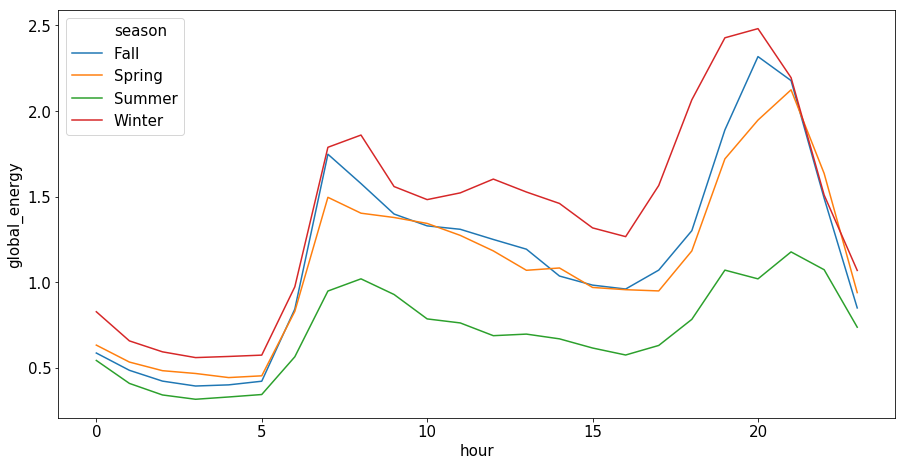

In [7]:
#plot the graph
sns.lineplot(x="hour", y="global_energy", data=seasonal_hourly_data, hue="season")

# 3 Clustering
### 3.1 Explore potential clusters of submeters
##### Create dataframe with relevant features


In [21]:
#extract relevant data
cluster_col = ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
cluster_df = full_year.loc["2008", cluster_col].groupby(pd.Grouper(freq="10Min")).sum().copy() 

#add time, day, and month columns, change index, and name columns 
cluster_df["time_id"] = cluster_df.index.hour + (0.01 * cluster_df.index.minute)
cluster_df["day"] = cluster_df.index.day
cluster_df["month"] = cluster_df.index.month
cluster_df = cluster_df.reset_index(drop = True)
cluster_df.columns = ["kitchen", "laundry", "heating", "time_id", "day", "month"]

#sample and create individual df's
cluster = cluster_df.sample(frac = 0.2, random_state = 42)
cluster_kitchen = cluster.loc[:, ["kitchen", "time_id", "day", "month"]]
cluster_laundry = cluster.loc[:, ["laundry", "time_id", "day", "month"]]
ccluster_heating = cluster.loc[:, ["heating", "time_id", "day", "month"]]

#k-means clustering
kmeans_kitchen = KMeans(n_clusters = 3)
kmeans_kitchen.fit(cluster_kitchen)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

##### Extract centroids and cluster labels per submeter + plot clusters

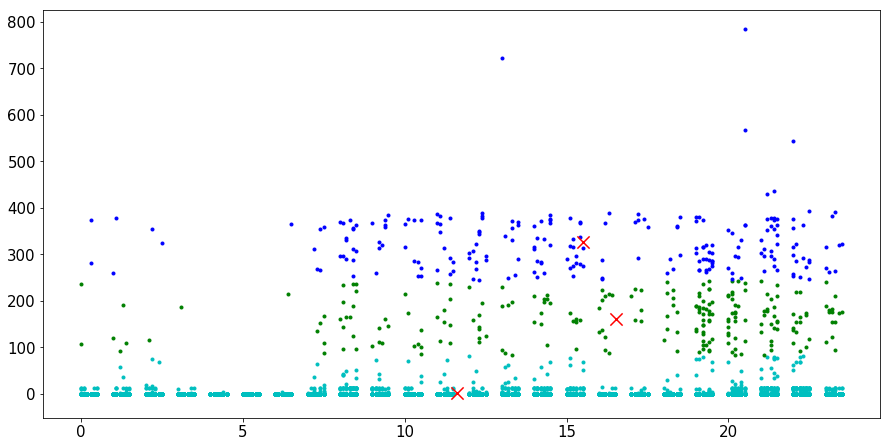

In [186]:
#extract centroids and labels and set colors
labels_kitchen = kmeans_kitchen.labels_
centroids_kitchen = kmeans_kitchen.cluster_centers_
colors_kitchen = ["c.", "g.", "b."]

#plot clusters
for i in range(len(labels_kitchen)):
    plt.plot(cluster_kitchen["time_id"].iloc[i], cluster_kitchen["kitchen"].iloc[i], colors_kitchen[labels_kitchen[i]])

#plot centroids and show plot
plt.scatter(centroids_kitchen[:, 1], centroids_kitchen[:, 0], marker = "x", s = 150, linewidths = 15, zorder = 10, color = "r")
plt.show()

### 3.2 Elbow Method
##### Visualize optimal number of clusters:

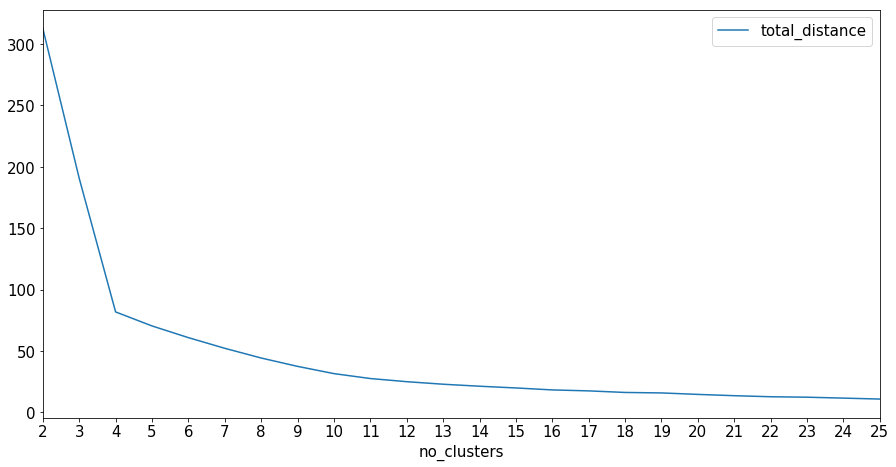

In [22]:
#define function that produces elbow output
def elbow_method(data, cluster_list, iterations = 10, plot = True):
    '''
    Outputs distance metric as dataframe for different #of clusters and plots graph for the elbow method.
    Input: dataframe with > 1 feature, cluster_list with list of integers, number of iterations per algorithm (optional)
    '''
    distances = {}
    df_labeled = data.copy()
    for i in cluster_list:
        kmeans = KMeans(n_clusters = i, n_init = iterations)
        kmeans.fit(data)
        distances[i] = kmeans.inertia_
    df_distance = pd.DataFrame.from_dict(distances, orient = "index", columns = ["total_distance"])
    df_distance.index.names = ["no_clusters"]   
    df_labeled["labels"] = kmeans.labels_
    
    #output graph and return distance values
    if plot == True:
        df_distance.plot(xticks = cluster_list, xlim = (min(cluster_list), max(cluster_list)))
    if len(cluster_list) > 1:
        return df_distance, df_labeled
    else:
        return df_labeled

#plot elbow method
cluster_submeters = cluster_df[["kitchen", "laundry", "heating"]]
cluster_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
cluster_metrics_test, cluster_labeled_test = elbow_method(cluster_submeters, cluster_list, iterations = 20)

##### Plot submeter energy consumption with 4 clusters:

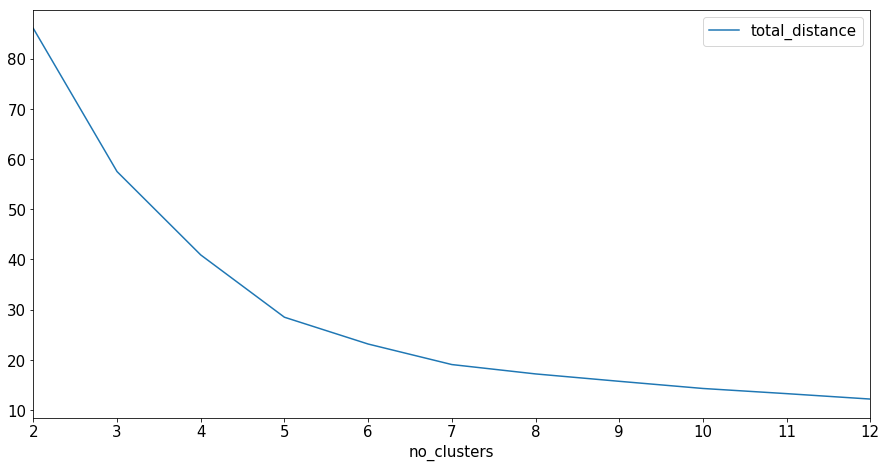

In [34]:
#plot elbow method for 3 submeters + remaining energy
test = submeter.loc["2008"]

test_metrics, test_labeled = elbow_method(test, cluster_list, iterations = 10)


### 3.3 3D Visualization
##### Visualize 21 clusters of the 3 submeters:

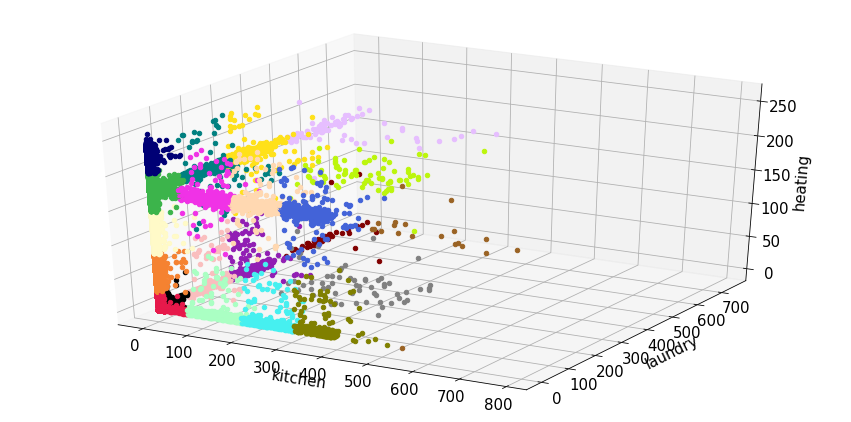

In [41]:
#get labels for n_clusters = 21
cluster_labeled_submeter = elbow_method(cluster_submeters, cluster_list=[21], iterations = 20, plot = False)

#%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')
#cluster_colors_submeter = ["r", "g", "b", "c", "m", "y", "k"]
cluster_colors_submeter = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']

for i in range(len(cluster_labeled_submeter["kitchen"])):
    ax.scatter3D(cluster_labeled_submeter["kitchen"].iloc[i], cluster_labeled_submeter["laundry"].iloc[i], \
                 cluster_labeled_submeter["heating"].iloc[i], c = cluster_colors_submeter[cluster_labeled_submeter["labels"].iloc[i]])
    
ax.set_xlabel("kitchen")
ax.set_ylabel("laundry")
ax.set_zlabel("heating")

plt.show()

# 4 Forecasting
### 4.1 Checking for stationarity
##### Visualizing stationarity

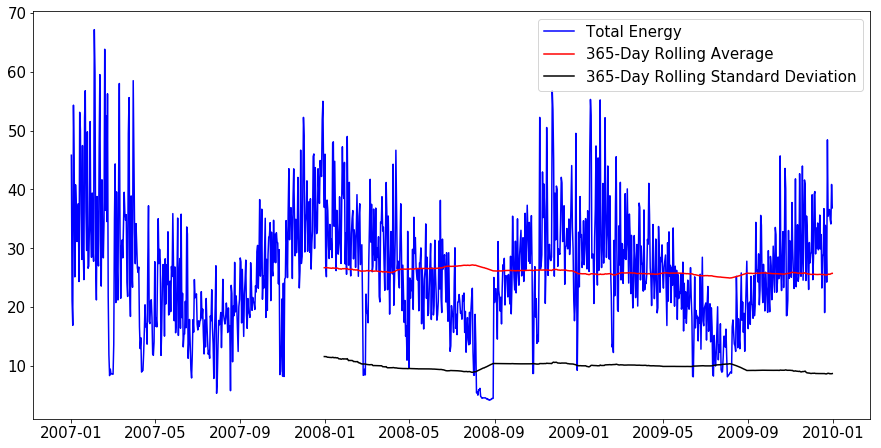

In [61]:
#calculating rolling mean and std
rolmean = daily_data["global_energy"].rolling(window = 365).mean()
rolstd = daily_data["global_energy"].rolling(window = 365).std()

#plot graph

orig_plot = plt.plot(daily_data["global_energy"], color = "b", label = "Total Energy")
mean_plot = plt.plot(rolmean, color = "r", label = "365-Day Rolling Average")
std_plot = plt.plot(rolstd, color = "k",  label = "365-Day Rolling Standard Deviation")
plt.legend(loc = "best")
plt.show()

##### Calculating stationarity

In [70]:
#use Dickey-Fuller test
dftest = adfuller(daily_data["global_energy"], autolag = "AIC")
p_val = dftest[1]

print("p-value = " + str(round(p_val * 100, 2)) + "%") #p < 5% --> time-series is in fact stationary

p-value = 2.43%


### 4.2 Forecasting w/ fbprophet
##### Preparding data and optimizing forecast

In [5]:
#prepare input data
input_data = daily_data.copy()
input_data.reset_index(inplace = True)
input_data = input_data[["Date_Time", "global_energy"]]
input_data.columns = ["ds", "y"]

#get real 2010 values
values_2010 = df.loc["2010"].copy()
values_2010["global_energy"] = values_2010["Global_active_power"] / 60 #convert to kWh
values_2010 = values_2010["global_energy"]
values_2010 = values_2010.groupby(pd.Grouper(freq="D")).sum()
num_pred = len(values_2010)


#optimize forecast model
def optimal_forecast(data, period, param_list, print_df = False, plot = False, plot_real = False, 
                     today = None, limit = None, calc_MAE = False, title = None):
    MAE_dict = {}
    for p in param_list:
        #fit model
        forecast_model = fbprophet.Prophet(changepoint_prior_scale = p, daily_seasonality = True, yearly_seasonality = True)
        forecast_model.fit(data)
        
        #predict
        predictions = forecast_model.make_future_dataframe(periods = period, freq = "D")
        predictions = forecast_model.predict(predictions)

        #calculating MAE
        if calc_MAE == True:
            values_pred = predictions[["ds", "yhat"]].copy()
            values_pred = values_pred.set_index("ds")
            values_pred = values_pred.loc["2010"]
            absolute_error = 0
            for i in range(period):
                error  = np.absolute(values_pred.iloc[i] - values_2010.iloc[i])
                absolute_error += error
            MAE = absolute_error / period
            MAE_dict[p] = MAE[0]
    
        #plot graph
        if plot == True & len(param_list) == 1:
            pred_fig, pred_ax = plt.subplots()
            pred = forecast_model.plot(predictions, xlabel = "Date", ylabel = "Total Energy in kWh", ax = pred_ax)
            if plot_real == True:
                real = pred_ax.scatter(x = values_2010.index, y = values_2010, color = "r", s = 6)
            if today != None:
                pred_ax.axvline(pd.to_datetime(today), color = "r", linestyle = "dashed")
                y_min, y_max = plt.ylim()
                pred_ax.text(mdates.date2num(today), y_max - 5, "Today", fontsize = 15, color = "red")
            if limit == None:
                plt.show()
            else:
                pred_ax.set_xlim([limit[0], limit[1]])
            if title != None:
                pred_ax.set_title(f"Energy Forecast for this {title}")
                plt.show()

    MAE_df = pd.DataFrame.from_dict(MAE_dict, orient = "index", columns = ["MAE"])
    MAE_df.index.names = ["parameter"]
    if print_df == True:
        print(MAE_df)
    
    if len(param_list) > 1:
        print("\n", "The best performing model is:", "\n", MAE_df[MAE_df["MAE"] == MAE_df["MAE"].min()])

##### Test different parameters to find the optimal model:

In [478]:
#find best model
forecast_param = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 
                  0.10, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
optimal_forecast(input_data, num_pred, forecast_param, print_df = True, calc_MAE = True)

                MAE
parameter          
0.01       4.921474
0.02       4.900795
0.03       4.893066
0.04       4.898839
0.05       4.888522
0.06       4.888365
0.07       4.882425
0.08       4.874623
0.09       4.868442
0.10       4.865382
0.15       4.834461
0.20       4.813456
0.30       4.865139
0.40       5.027236
0.50       5.300853
0.60       5.513796
0.70       5.608118
0.80       5.875319
0.90       6.374233

 The best performing model is: 
                 MAE
parameter          
0.2        4.813456


##### Plot best forecast:

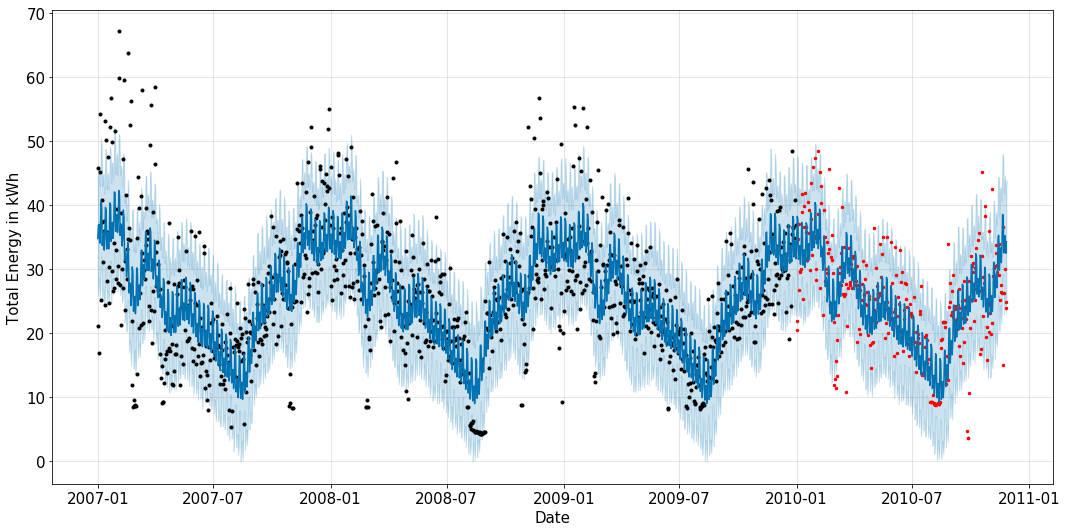

In [452]:
#plot forecast with best performing parameter
optimal_forecast(input_data, num_pred, param_list = [0.2], plot = True, plot_real = True, title = "Year 2010")

# 5 Dashboard
### 5.1 Preparing the analysis
##### Preparing the data:

In [4]:
#preparing data sets
daily_data = full_year.groupby(pd.Grouper(freq="D")).sum()
daily_data["global_energy_rolling"] = daily_data["global_energy"].rolling(7).mean()
daily_data["Sub_metering_1_rolling"] = daily_data["Sub_metering_1"].rolling(7).mean()
daily_data["Sub_metering_2_rolling"] = daily_data["Sub_metering_2"].rolling(7).mean()
daily_data["Sub_metering_3_rolling"] = daily_data["Sub_metering_3"].rolling(7).mean()
hourly_data = full_year.groupby(pd.Grouper(freq="H")).sum()

##### Defining formulas to display charts:

In [15]:
#define daily plotting function
energy_dict = {"Total":["global_energy", "r"], "Kitchen":["Sub_metering_1", "b"], "Laundry Room":["Sub_metering_2", "c"], "Heating & AC":["Sub_metering_3", "g"]}

def plot_daily(start, end, energy, chart):
    selected_energy = [energy_dict[i][0] for i in energy]
    if chart == "7-Day Average":
        selected_col = ["_".join([i, "rolling"]) for i in selected_energy]
    else:
        selected_col = selected_energy
        
    #plot graph
    daily_fig, daily_ax = plt.subplots()
    for i in range(len(selected_col)):
        daily_ax.plot(daily_data.loc[start:end, [selected_col[i]]], color = energy_dict[energy[i]][1], label = energy[i])
    daily_ax.set_title("Daily Energy Consumption in kWh")
    daily_ax.legend(loc = "upper right")
    daily_ax.grid()
    plt.show()
   

#define house overview function
room_coordinates_sizes = {"remaining_energy":(332, 400, 50000), "Sub_metering_1":(830, 602, 15000), 
                          "Sub_metering_2":(1161, 602, 15000), "Sub_metering_3":(1000, 203, 25000)} #(x, y, size)
img = plt.imread("/Users/nicolausholzach/Desktop/Dateien/Ubiqum/Projects/Project 3/P3_Task 1/Project3_House.png")

def plot_house(date, time):
    #set range
    selected_hour = datetime.datetime(date.year, date.month, date.day, int(time[:2]))
    week_before = selected_hour - datetime.timedelta(days = 7)
    values = list(hourly_data.loc[selected_hour, ["remaining_energy", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]])
    
    #set color map
    cmap = matplotlib.cm.get_cmap('plasma')
    max_consumption = hourly_data.loc[week_before : selected_hour, ["remaining_energy", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].max().max()
    min_consumption = hourly_data.loc[week_before : selected_hour:, ["remaining_energy", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].min().min()
    normalized_minmax = matplotlib.colors.Normalize(vmin = min_consumption, vmax = max_consumption)
    colors = dict(zip(["remaining_energy", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"],
                      [cmap(normalized_minmax(i)) for i in values]))
                      
    #plot graph
    house_fig, house_ax = plt.subplots(figsize=(15, 7.5))
    for k, v in room_coordinates_sizes.items():
        house_ax.scatter(x = v[0], y = v[1], s = v[2], color = colors[k], alpha = 0.4, linewidths = 10)
    house_ax.imshow(img)
    house_ax.set_title(f"Energy Overview: {selected_hour}")
    
    #remove axis ticks and labels
    house_ax.set_yticklabels([])
    house_ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    
    #add a colorbar
    cax, _ = matplotlib.colorbar.make_axes(house_ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalized_minmax)
    #house_ax.set_ylabel('Hourly Energy Consumption (in kWh)')
    #house_ax.yaxis.set_label_position("right")
    print("\n", 
        f"Kitchen: {round(values[1],2)} kWh", "\n", f"Laundry: {round(values[2],2)} kWh", "\n",
        f"Heating: {round(values[3],2)} kWh", "\n", f"Remaining: {round(values[0],2)} kWh"
    )
    plt.show()
    

#define forecast function
def forecast_consumption(date, period):
    lastday_dict = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
    date_index = input_data[input_data["ds"] == pd.Timestamp(date)].index[0]
    forecast_input = input_data.iloc[:date_index + 1, ]
    
    #calculate number of days to be forecasted
    if period == "Week":
        forecast_days = 6 - date.weekday()
        start = date - datetime.timedelta(days = date.weekday())
    elif period == "Month":
        forecast_days = lastday_dict[date.month] - date.day
        start = datetime.datetime(date.year, date.month, 1)
    elif period == "Year":
        forecast_days = 365 - date.timetuple().tm_yday
        start = datetime.datetime(date.year, 1, 1)
    
    #set limit to display axes of graph
    limit = (start, date + datetime.timedelta(days = forecast_days))
        
    #calculate and plot forecast
    optimal_forecast(data = forecast_input, period = forecast_days, param_list = [0.2], plot = True, today = date, limit = limit, title = period)

### 5.2 Creating the widgets
##### Tab 1 - Historic Consumption:

In [24]:
#calendar widgets
start = widgets.DatePicker(description='Start date:', disabled=False)
end = widgets.DatePicker(description='End date:', disabled=False)

#widget to pick which energy consumption to view
energy_pick = widgets.SelectMultiple(options=['Total', 'Kitchen', 'Laundry Room', 'Heating & AC'], value=["Total"], description='Energy:')

#widget to select type of analysis
chart = widgets.ToggleButtons(options=['Standard', '7-Day Average'], description='Chart:', 
        value="Standard", disabled=False, button_style='info')


##### Tab 2 - House Overview:

In [8]:
#second calendar widget
calendar = widgets.DatePicker(description='Date:', disabled=False)

#time slider widget
time_list = ["00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00", "07:00", "08:00",
            "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00",
            "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"]
time_slider = widgets.SelectionSlider(options = time_list, value="12:00", disabled=False)

##### Tab 3 - Forecasts

In [9]:
#third calendar widget
forecast_date = widgets.DatePicker(description='Today:', disabled=False)

#widget to select weekly, monthly, or yearly forecast
forecast_pick = widgets.RadioButtons(options=['Week', 'Month', 'Year'], value="Month", description='Forecast:')

##### Combine Tabs:

In [10]:
#create dashboard
dashboard = widgets.Tab()
dashboard.set_title(0, 'Historic Consumption')
dashboard.set_title(1, "House Overview")
dashboard.set_title(2, "Energy Forecast")

#create overarching tabs
consumption_tab = interactive(plot_daily, start=start, end=end, energy=energy_pick, chart=chart)
house_tab = interactive(plot_house, date=calendar, time=time_slider)
forecast_tab = interactive(forecast_consumption, date=forecast_date, period=forecast_pick)

#create tab 1
consumption_date = widgets.HBox(consumption_tab.children[0:2])
consumption_energy_chart = widgets.HBox(consumption_tab.children[2:4])
tab_1 = widgets.VBox([consumption_date, consumption_energy_chart, consumption_tab.children[4]])

#create tab 2
house_date_time = widgets.HBox([calendar, time_slider])
tab_2 = widgets.VBox([house_date_time, house_tab.children[2]])

#create tab 3
forecast_date_period = widgets.HBox([forecast_date, forecast_pick])
tab_3 = widgets.VBox([forecast_date_period, forecast_tab.children[2]])

#combine tabs into dashboard
dashboard.children = [tab_1, tab_2, tab_3]

### 5.3 Interact with Dashboard

In [14]:
#display dashboard
plt.clf()
dashboard

<Figure size 1080x540 with 0 Axes>